<a href="https://colab.research.google.com/github/JeanMichelDeveloper/Training/blob/main/Drawing_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load drawing dataset

In [57]:
#install wget
!pip3 install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
#import necessary libraries
import wget
import os
import numpy
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
from PIL import Image
from PIL import ImageOps
from IPython import display 

In [59]:
#download data for specified categories

dataset_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

categories = ["face"]

for category in categories:

  if not os.path.exists("/" + str(category) + ".npy"):
    url_to_category_dataset = dataset_url + str(category) + ".npy"
    wget.download(url = url_to_category_dataset,
                out = ""
                )
  else:
    print("Dataset already downloaded")

Label data

In [60]:
#create classes dictionary
classes_dictionary ={}

for category in categories:
  classes_dictionary[category] = numpy.load(str(category) + ".npy")

#add a label to the data
for index, (key, value) in enumerate(classes_dictionary.items()):
  value = value.astype("float32")

  print(len(classes_dictionary))

  if index == 0:
    classes_dictionary[key] = numpy.c_[value, numpy.zeros(len(value))]

  else:
    classes_dictionary[key] = numpy.c_[value, index*numpy.ones(len(value))]

1


Build a training dataset

In [61]:
data = []
training_samples = 5000

#create dataset
for key, value in classes_dictionary.items():
  data.append(value[:training_samples])

numpy_data = numpy.concatenate(data)

#splip dataset
train_x = numpy_data[:, :784]
train_y = numpy_data[:, -1].astype("int")

#reshape
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype("float32")
train_x.shape

#normalize
normalization_value = 127.5
train_x = (train_x - normalization_value) / normalization_value


Visualize dataset

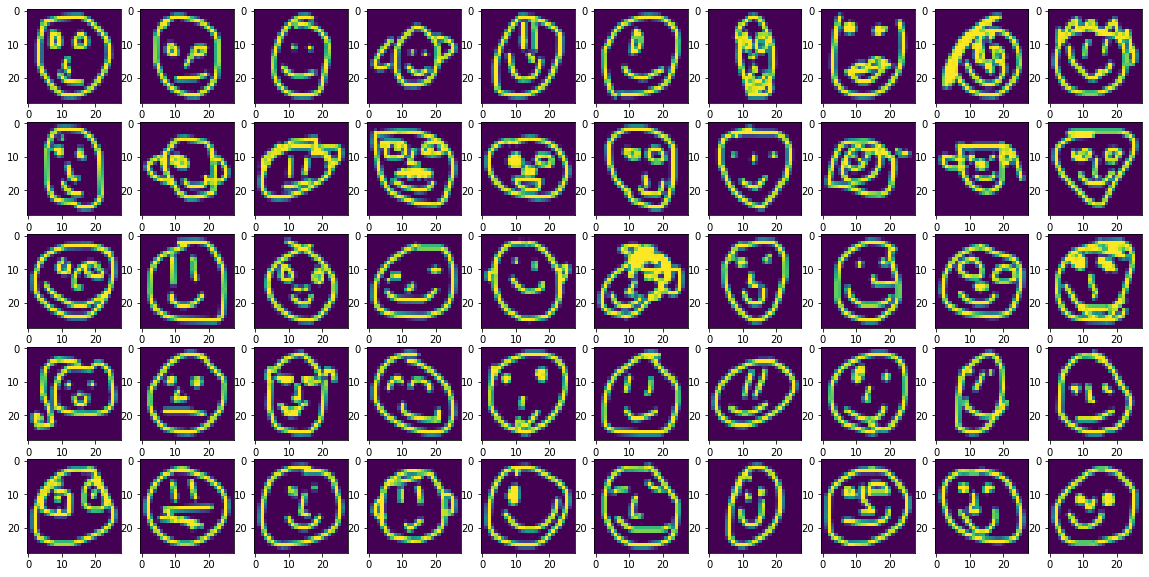

In [62]:
#define function that shows 50 random images from the dataset
def visualize_dataset(x, y):
  figure, axes = plt.subplots(5, 10, figsize=(20, 10))

  for label in range(0, 50):
    random_label = random.randint(0, len(x) - 1)
    image = x[random_label].reshape(28, 28)
    x_coordinate = label // 10
    y_coordinate = label % 10
    axes[x_coordinate, y_coordinate].imshow(image)
  
  plt.show()

visualize_dataset(train_x, train_y)

Batch and shuffle data

In [63]:
#convert to tensor, shuffle and batch data
shuffle_size = 5000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(shuffle_size).batch(batch_size)

Build a generator

In [64]:
#define each layer of the model
def generator_layers():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, 
                         use_bias = False,
                         input_shape = (100,),
                         ))
  
  model.add(layers.BatchNormalization())

  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128,
                                   (5, 5),
                                   strides = (1, 1),
                                   padding = "same",
                                   use_bias = False))
  
  assert model.output_shape == (None, 7, 7, 128)

  model.add(layers.BatchNormalization())

  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,
                                   (5, 5),
                                   strides = (2, 2),
                                   padding = "same",
                                   use_bias = False))
  
  assert model.output_shape == (None, 14, 14, 64)

  model.add(layers.BatchNormalization())

  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,
                                   (5, 5),
                                   strides = (2, 2),
                                   padding = "same",
                                   use_bias = False,
                                   activation = "tanh"))
  
  assert model.output_shape == (None, 28, 28, 1)
  
  return model

Generate noise

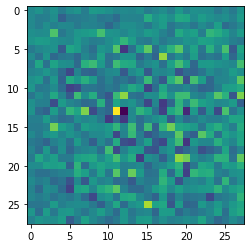

In [65]:
#create generator
generator = generator_layers()

#create and display noisy image as a starting point for training
random_noise = tf.random.normal([1, 100])

noisy_image = generator(random_noise, training = False)

plt.imshow(noisy_image[0, :, :, 0])

Build a discriminator

In [66]:
#define each layer of the model
def discriminator_layers():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, 
                          (5, 5), 
                          strides = (2, 2),
                          padding = "same",
                          input_shape = [28, 28, 1]))
  
  model.add(layers.LeakyReLU())

  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, 
                          (5, 5), 
                          strides = (2, 2),
                          padding = "same"))
  
  model.add(layers.LeakyReLU())

  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())

  model.add(layers.Dense(1))

  return model

#create discriminator
discriminator = discriminator_layers()

#test discriminator
prediction = discriminator(noisy_image)

print(prediction)

tf.Tensor([[0.00155177]], shape=(1, 1), dtype=float32)


Calculate loss

In [67]:
#define loss calculating functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def calculate_generator_loss(fake_image):
  return cross_entropy(tf.ones_like(fake_image), fake_image)

def calculate_discriminator_loss(real_image, fake_image):
  real_image_loss = cross_entropy(tf.ones_like(real_image), real_image)
  fake_image_loss = cross_entropy(tf.zeros_like(fake_image), fake_image)
  total_loss = real_image_loss + fake_image_loss
  return total_loss

Assign optimizers

In [68]:
#create optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Build a training step

In [69]:
#define step function
noise_dimension = 100
@tf.function

def step(images):
  noise = tf.random.normal([batch_size, noise_dimension])

  with tf.GradientTape() as generator_gradient_tape, tf.GradientTape() as discriminator_gradient_tape:
    generated_images = generator(noise, training = True)

    real_image_prediction = discriminator(images, training = True)

    fake_image_prediction = discriminator(generated_images, training = True)

    generator_loss = calculate_generator_loss(fake_image_prediction)

    discriminator_loss = calculate_discriminator_loss(real_image_prediction, fake_image_prediction)

  generator_gradients = generator_gradient_tape.gradient(generator_loss, generator.trainable_variables)

  discriminator_gradients = discriminator_gradient_tape.gradient(discriminator_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

Visualize training

In [70]:
#define function to visualize images generated during training
def visualize_images(model, test_input):
  predictions = model(test_input, training = False)

  for index in range(predictions.shape[0]):
    plt.subplot(3, 3, index + 1)
    plt.imshow(predictions[index, :, :, 0] * normalization_value + normalization_value)
  
  plt.show()

Train the model

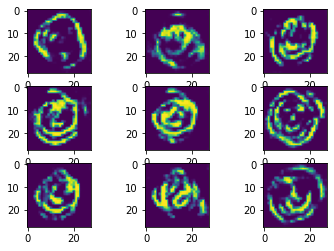

3


KeyboardInterrupt: ignored

In [76]:
#define training function
epochs = 200
samples = 9
seed_value = tf.random.normal([samples, noise_dimension])
def train(dataset, epochs):
  for epoch in range(epochs):
    print(epoch)
    for batch in dataset:
      step(batch)
    display.clear_output(wait = True)
    
    visualize_images(generator, seed_value)
#train the model
train(train_dataset, epochs)

Test the model

In [78]:
#define testing function
def generate_image(model):
  number_of_images = 1
  
  seed_value = tf.random.normal([number_of_images, noise_dimension])

  result = model(seed_value, training = False)

  numpy_result = result[0].numpy()

  numpy_result = numpy_result * normalization_value + normalization_value

  result_image = Image.fromarray(numpy_result.reshape((28, 28))).convert("RGB")

  resized_image = result_image.resize((300, 300))

  return ImageOps.invert(resized_image)

#create image
generated_image = generate_image(generator)